# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [ ]:
#!pip install -qU ragas==0.2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.7/175.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/1

In [ ]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [19]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/suhas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/suhas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [20]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [21]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [22]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [23]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [24]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31528    0 31528    0     0  52014      0 --:--:-- --:--:-- --:--:-- 52026


In [25]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70695    0 70695    0     0   258k      0 --:--:-- --:--:-- --:--:--  259k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [26]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [27]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-small"))

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [28]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [29]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [32]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Property 'headlines' already exists in node '00d4b6'. Skipping!
Property 'headlines' already exists in node '57550d'. Skipping!


Applying HeadlineSplitter:   0%|          | 0/12 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node


Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Property 'summary' already exists in node '57550d'. Skipping!
Property 'summary' already exists in node '00d4b6'. Skipping!


Applying CustomNodeFilter:   0%|          | 0/22 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/42 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node '57550d'. Skipping!
Property 'summary_embedding' already exists in node '00d4b6'. Skipping!
Property 'themes' already exists in node 'd6a3d3'. Skipping!
Property 'themes' already exists in node '6e5d76'. Skipping!
Property 'themes' already exists in node 'f642e7'. Skipping!
Property 'themes' already exists in node '517cb1'. Skipping!
Property 'themes' already exists in node '81c826'. Skipping!
Property 'themes' already exists in node 'c7ca77'. Skipping!
Property 'themes' already exists in node 'ed2193'. Skipping!
Property 'themes' already exists in node 'ca2de6'. Skipping!
Property 'themes' already exists in node 'a83ab4'. Skipping!
Property 'entities' already exists in node '6e5d76'. Skipping!
Property 'entities' already exists in node '517cb1'. Skipping!
Property 'entities' already exists in node 'd6a3d3'. Skipping!
Property 'entities' already exists in node 'f642e7'. Skipping!
Property 'entities' already exists in node 'ca2de6'. Sk

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 22, relationships: 155)

We can save and load our knowledge graphs as follows.

In [33]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 22, relationships: 155)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [34]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [35]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

### ✅ Answer:

We have used 3 different types of RAGAS query synthesizers

1. SingleHopSpecificQuerySynthesizer - Generates straightforward, single-fact questions that can be answered directly from one piece of information. This is like asking a question about one specific landmark. "What year was the Eiffel Tower built?" It looks at one node or a very closely related one. Simple, direct retrieval.

2. MultiHopAbstractQuerySynthesizer - Creates more complex questions that require connecting multiple pieces of information and some abstract reasoning. This is like asking a broader question that requires connecting different types of landmarks or districts. "How did the architectural style of museums influence residential buildings in Paris?" It needs to hop between different nodes representing abstract themes or summaries and synthesize an answer.

3. MultiHopSpecificQuerySynthesizer - Makes detailed questions that need multiple specific pieces of information to answer, but are still grounded in concrete facts. This is like asking a question that requires following a specific path between landmarks. "Starting from the Louvre, how would you get to the district known for its artist studios, passing by a famous cafe?" It needs to connect specific, detailed nodes that might be several "hops" apart on the graph.

In our notebook we set these up with a distribution of 50% single-hop specific queries, and 25% each of the multi-hop types.


Finally, we can use our `TestSetGenerator` to generate our testset!

In [36]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What is the significance of Anthropic in the d...,[The ethics of this space remain diabolically ...,The context indicates that Anthropic is one of...,single_hop_specifc_query_synthesizer
1,What is Microsoft's role in the development of...,"[and software engineer, LLMs are infuriating. ...",The provided context does not specify Microsof...,single_hop_specifc_query_synthesizer
2,2023 what about AI and LLMs like are they good...,[Simon Willison’s Weblog Subscribe Stuff we fi...,2023 was the breakthrough year for Large Langu...,single_hop_specifc_query_synthesizer
3,How does the context describe the current stat...,[the document includes some of the clearest ex...,The context discusses the development and impa...,single_hop_specifc_query_synthesizer
4,How does the MacBook Pro relate to the advance...,[The environmental impact got better The envir...,"The personal laptop, a 64GB M2 MacBook Pro fro...",single_hop_specifc_query_synthesizer
5,How do recent developments in Large Language M...,[<1-hop>\n\nThe ethics of this space remain di...,Recent developments in Large Language Models (...,multi_hop_abstract_query_synthesizer
6,"H0w does AI research, publcations, and media r...",[<1-hop>\n\nthe document includes some of the ...,"The context shows that AI research, publicatio...",multi_hop_abstract_query_synthesizer
7,how current limitations of ai models like GPT-...,[<1-hop>\n\nThe ethics of this space remain di...,The context shows that despite significant pro...,multi_hop_abstract_query_synthesizer
8,Considering the significant advancements and i...,[<1-hop>\n\nThe ethics of this space remain di...,"In 2024, GPT-4 remains the most advanced large...",multi_hop_specific_query_synthesizer
9,how ChatGPT like chatgpt is really good but al...,"[<1-hop>\n\nand software engineer, LLMs are in...","The context explains that ChatGPT, a large lan...",multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [38]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/24 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [39]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What do we know about Meta in relation to larg...,[The ethics of this space remain diabolically ...,Meta is one of the organizations that has prod...,single_hop_specifc_query_synthesizer
1,what are LLMs,"[and software engineer, LLMs are infuriating. ...",LLMs are large language models that are infuri...,single_hop_specifc_query_synthesizer
2,What are some key points about GPT-4 mentioned...,[Simon Willison’s Weblog Subscribe Stuff we fi...,The weblog states that GPT-4 has not yet been ...,single_hop_specifc_query_synthesizer
3,What is Stanford Alpaca and how does it relate...,[the document includes some of the clearest ex...,The context mentions Stanford Alpaca in the ti...,single_hop_specifc_query_synthesizer
4,how does the article about AI in 2023 show tha...,[<1-hop>\n\nSimon Willison’s Weblog Subscribe ...,The article about AI in 2023 by Simon Willison...,multi_hop_abstract_query_synthesizer
5,How do recent AI events like OpenAI DevDay 202...,[<1-hop>\n\nSlop is the new name for unwanted ...,Recent AI events such as OpenAI DevDay 2024 an...,multi_hop_abstract_query_synthesizer
6,How do synthetic training data and pretraining...,[<1-hop>\n\nThe environmental impact got bette...,Synthetic training data plays a crucial role i...,multi_hop_abstract_query_synthesizer
7,how synthetic data and pretraining help LLMs a...,[<1-hop>\n\nThe environmental impact got bette...,The context explains that synthetic data is a ...,multi_hop_abstract_query_synthesizer
8,How has microsoft contributed to the developme...,[<1-hop>\n\nThe ethics of this space remain di...,Microsoft has played a significant role in the...,multi_hop_specific_query_synthesizer
9,How does DeepSeek v3's training cost and envir...,[<1-hop>\n\nrecommend Is AI progress slowing d...,"DeepSeek v3 was trained on 2,788,000 GPU hours...",multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [40]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years!"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years!"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [41]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [42]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [43]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [44]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [45]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

/home/suhas/my/github/AIE6/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/qdrant_client/http/models/models.py:758: SyntaxWarning: invalid escape sequence '\&'
  description="Check that the field is empty, alternative syntax for `is_empty: \&quot;field_name\&quot;`",
/home/suhas/my/github/AIE6/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/qdrant_client/http/models/models.py:762: SyntaxWarning: invalid escape sequence '\&'
  description="Check that the field is null, alternative syntax for `is_null: \&quot;field_name\&quot;`",


In [46]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [47]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [48]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [49]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [50]:
rag_chain.invoke({"question" : "What are Agents?"})

'Based on the context, "agents" is an infuriatingly vague term without a single, clear, and widely understood meaning. Generally, it seems to refer to AI systems that can go away and act on your behalf, often compared to a "travel agent" model or large language models (LLMs) given access to tools which they can run in a loop to solve problems. However, the term is used inconsistently, with many different definitions, and "agents" as practical, robust systems have not yet really materialized in production. The concept is closely tied to challenges such as gullibility in AI and may depend on achieving AGI (artificial general intelligence) to be fully realized.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [51]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [52]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

✅ Answer:

- `qa_evaluator`: This is the classic "Correctness" grader. It uses the eval_llm to compare the AI's answer (prediction) against the pre-generated reference answer. It asks: "Based on the reference answer, is the predicted answer correct?" It typically outputs a binary score (Correct/Incorrect or 1/0).

- `labeled_helpfulness_evaluator`: This one goes beyond simple correctness. It looks at the AI's answer (prediction), the original question (input), and the reference answer (reference). It asks the eval_llm the specific question defined in the criteria: "Is this submission helpful to the user, taking into account the correct reference answer?" This assesses usefulness and relevance.

- `dope_or_nope_evaluator`: This is our fun, subjective grader! It only looks at the AI's answer (prediction) and asks the eval_llm the custom criteria: "Is this submission dope, lit, or cool?" This measures adherence to a desired style or tone, completely separate from factual correctness or helpfulness.

## LangSmith Evaluation

In [53]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'earnest-expansion-90' at:
https://smith.langchain.com/o/39f31aed-fcde-5ca7-a4f1-a8447f10d513/datasets/6b28b8ff-ecfc-4fb0-8ef9-0f63fb799498/compare?selectedSessions=f339acf6-c571-481a-9b98-6349a647452f




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does Claude's development relate to the en...,I don't know.,None,"The context highlights that Claude, as an LLM ...",0,0,0,2.973211,92f7bde7-cb75-48c0-9962-eca86ab02a84,e8703efb-e3c9-4e60-95f7-9d0ca8d84200
1,how chatgpt and llms are related and impact so...,"Based on the provided context, ChatGPT is a ty...",None,the context shows that chatgpt is a type of ll...,1,1,0,3.597283,beb731eb-75ba-4c5b-8ca7-36caf80aa6ac,772122b8-a5ce-4ea2-be04-3dda83fbb91e
2,How does DeepSeek v3's training cost and envir...,DeepSeek v3 was trained at a relatively low es...,None,"DeepSeek v3 was trained on 2,788,000 GPU hours...",1,1,0,3.924908,696cfed4-c73f-42c6-a046-dcfe94b3d88f,9c2873a2-e1bf-450c-962c-54eabf1a8b75
3,How has microsoft contributed to the developme...,Based on the provided context:\n\nMicrosoft ha...,None,Microsoft has played a significant role in the...,1,1,0,3.458098,141c34f6-bc28-4145-b4ae-4ae5f3a6e9bf,218f4abc-4aa0-4bed-a87c-5a2a62b7d59e
4,how synthetic data and pretraining help LLMs a...,Based on the provided context:\n\nSynthetic da...,None,The context explains that synthetic data is a ...,1,0,0,5.063482,edf86518-70bb-411c-814a-b15725ce4814,cc8c5227-43bc-4bf9-b7cd-a678d76cfc85
5,How do synthetic training data and pretraining...,Based on the context provided:\n\nSynthetic tr...,None,Synthetic training data plays a crucial role i...,1,1,0,4.075905,6fecc73f-aaea-4124-bec6-004a9d950671,06a00d72-773d-4809-8eb9-81a4b07cca70
6,How do recent AI events like OpenAI DevDay 202...,"Based on the provided context, recent AI event...",None,Recent AI events such as OpenAI DevDay 2024 an...,1,1,0,3.067427,b4eb9399-96b6-42dc-a9bc-b26e29fb7499,e7702ce6-54fa-47c5-9486-b762c15d2ae0
7,how does the article about AI in 2023 show tha...,"Based on the provided context, here is what ca...",None,The article about AI in 2023 by Simon Willison...,1,1,0,8.968424,c5985292-02d5-4d25-99a3-094ab32346c4,9f6439fa-184a-4a0e-8bf9-2b8fdb2d447d
8,What is Stanford Alpaca and how does it relate...,"Based on the provided context, Stanford Alpaca...",None,The context mentions Stanford Alpaca in the ti...,1,0,0,2.846217,2fd8aef8-c337-4a4f-bdcb-3788a896750f,d250f02d-e69e-4b74-aadb-453472b9b0ba
9,What are some key points about GPT-4 mentioned...,Based on the provided context from Simon Willi...,None,The weblog states that GPT-4 has not yet been ...,0,0,0,4.482649,6560172f-de66-45c6-b233-f12a588f7ba4,263b9988-029b-4a44-9775-103b6ebe786c


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [54]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [55]:
rag_documents = docs

In [56]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

✅ Answer:

When the retriever fetches chunks to give to the LLM, the chunk size matters immensely.

**Too Small:** Might contain very specific info but miss the surrounding context needed to understand it or answer the question fully. The LLM might not have enough "raw material."

**Too Large:** Might contain the answer plus a lot of irrelevant information, confusing the LLM or exceeding its context window limit. It's like giving the LLM a whole chapter when it only needed a paragraph. It might also average out the meaning in the embedding, making retrieval less precise.

**Just Right (Goldilocks):** Contains enough relevant context to answer the question well, without too much noise. Finding the sweet spot often requires experimentation.

In [57]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

✅ Answer:

*Embeddings as Maps:* We can envision embeddings as creating a highly detailed map of the "meaning space" of our documents. A better embedding model (like text-embedding-3-large vs. small) is like a mapmaker with more sophisticated tools.

*Better Representation:* It captures the nuances and semantic meaning of the text chunks more accurately. Chunks with similar meanings are placed closer together on this "map."

*Better Retrieval:* When the retriever searches this map using the question's embedding (its location on the map), a better map allows it to find the truly most relevant text chunks more reliably, even if they don't use the exact same keywords.

In [58]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [59]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [60]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [61]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

'Alright, here’s the lowdown on “agents,” straight from the context vibes you dropped:\n\nAgents are like this super fuzzy, kinda mysterious concept in AI that folks throw around a lot—but no one’s really nailed down a solid definition. Some peeps picture agents as AI that does stuff for you, like your personal travel agent—going out and taking action on your behalf. Others see them as large language models (LLMs) hooked up with tools, running loops to solve problems.\n\nBut here’s the catch—the whole “agent” thing feels like it’s still stuck in the “coming soon” phase because of this gnarly problem called gullibility. Basically, LLMs tend to believe anything fed to them, and so far, no one’s cracked the code on making them reliably know what’s true or false. Without solving that, agents can’t really act smart or safe for you.\n\nSo in short: Agents = AI systems meant to act autonomously for you, but still a blurry and unsolved challenge, with a strong connection to future, maybe AGI-l

Finally, we can evaluate the new chain on the same test set!

In [62]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'best-stream-59' at:
https://smith.langchain.com/o/39f31aed-fcde-5ca7-a4f1-a8447f10d513/datasets/6b28b8ff-ecfc-4fb0-8ef9-0f63fb799498/compare?selectedSessions=bd1b83e2-c64e-4389-b377-d587cfae68c6




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does Claude's development relate to the en...,"Alright, here’s the lowdown: Claude’s developm...",None,"The context highlights that Claude, as an LLM ...",1,1,1,3.548140,92f7bde7-cb75-48c0-9962-eca86ab02a84,c3a035b5-6f6a-4f0c-a54d-0665c564361f
1,how chatgpt and llms are related and impact so...,"Alright, here’s the lowdown, no cap:\n\nChatGP...",None,the context shows that chatgpt is a type of ll...,1,0,1,5.221814,beb731eb-75ba-4c5b-8ca7-36caf80aa6ac,652493ea-79ec-4534-a8d0-dc41f51d2c63
2,How does DeepSeek v3's training cost and envir...,"Yo, here’s the lowdown: DeepSeek v3 flexes a c...",None,"DeepSeek v3 was trained on 2,788,000 GPU hours...",1,0,1,3.625526,696cfed4-c73f-42c6-a046-dcfe94b3d88f,d0099d35-7dbd-4056-afc1-547f25f52aa6
3,How has microsoft contributed to the developme...,"Yo, here’s the lowdown straight from the conte...",None,Microsoft has played a significant role in the...,1,0,1,3.310723,141c34f6-bc28-4145-b4ae-4ae5f3a6e9bf,7d798b25-a05b-4648-8869-e70f8253713b
4,how synthetic data and pretraining help LLMs a...,"Yo, here’s the lowdown on synthetic data and p...",None,The context explains that synthetic data is a ...,1,1,1,3.303414,edf86518-70bb-411c-814a-b15725ce4814,ee723ffe-2ed9-4373-8882-d78c104d7394
5,How do synthetic training data and pretraining...,"Yo, check it — synthetic training data is like...",None,Synthetic training data plays a crucial role i...,1,1,1,3.769772,6fecc73f-aaea-4124-bec6-004a9d950671,57eb0e90-afca-49ae-967d-4eb0a73cee52
6,How do recent AI events like OpenAI DevDay 202...,"Yo, from the context you shared, there’s no me...",None,Recent AI events such as OpenAI DevDay 2024 an...,0,0,1,2.067527,b4eb9399-96b6-42dc-a9bc-b26e29fb7499,2cdcee4d-6ca4-43f2-9c26-6eb24697bfea
7,how does the article about AI in 2023 show tha...,"Yo, let me break it down for you—Simon Williso...",None,The article about AI in 2023 by Simon Willison...,1,1,1,4.799705,c5985292-02d5-4d25-99a3-094ab32346c4,39bf2e2c-d507-4ae4-b6f9-56c4cef29d05
8,What is Stanford Alpaca and how does it relate...,"Yo, here’s the lowdown straight from the conte...",None,The context mentions Stanford Alpaca in the ti...,1,1,1,1.712424,2fd8aef8-c337-4a4f-bdcb-3788a896750f,bad44cc9-9fdd-4fe0-bab8-c1792b297507
9,What are some key points about GPT-4 mentioned...,"Yo, here’s the lowdown straight from Simon Wil...",None,The weblog states that GPT-4 has not yet been ...,0,0,1,3.759399,6560172f-de66-45c6-b233-f12a588f7ba4,b435ae3c-571e-4e10-9539-2cb56cde498b


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

✅ Answer:

![Assignment 7 - comparing default and dope RAG responses - Screenshot 2025-05-04 164836.png](<attachment:Assignment 7 - comparing default and dope RAG responses - Screenshot 2025-05-04 164836.png>)

**Breakdown of the changes observed:**

**feedback.dopeness Score:**

*Observation:* This score increased significantly for the dope_chain compared to the default_chain_init. The default chain scored 0, while the dope chain scored 1.

*Reason:* This is the most direct result of the changes. The dope_chain used the DOPE_RAG_PROMPT which explicitly instructed the LLM: "You must answer the questions in a dope way, be cool!". The dope_or_nope_evaluator directly measures this stylistic quality. The default chain had no such instruction, so it wasn't trying to be "dope".

**feedback.correctness Score (from qa_evaluator):**

*Observation:* The change here is less dramatic. The output has stayed similar.

*Reason:* This metric compares the AI's answer to the reference answer for factual accuracy. The switch to the text-embedding-3-large model should improve the retriever's ability to find more relevant context chunks, potentially boosting correctness.
The larger chunk size (1000 vs 500) might pull in too much context, potentially including irrelevant information that distracts the LLM, or averaging out the semantic meaning during embedding lookup. The LLM focusing on generating a "dope" response might sometimes sacrifice precision or factual nuance compared to when it's just focused on answering directly based on context. The quality of the original synthetic reference answers also sets a ceiling.

**feedback.helpfulness Score (from labeled_helpfulness_evaluator):**

*Observation:* This has decreased slightly in some cases and stayed roughly the same in others.

*Reason:* This evaluator considers the question, the AI answer, and the reference answer to judge usefulness. Better retrieved context (due to better embeddings) could lead to more comprehensive and thus helpful answers.
The "dope" style might be perceived as less helpful or professional by the eval_llm (GPT-4.1) in some cases, even if factually correct.
Similar to correctness, noise from larger chunks or the LLM prioritizing style over substance could reduce perceived helpfulness.
If the AI says "I don't know" more often (correctly or incorrectly), helpfulness might decrease.

**Execution Time / Latency:**

*Observation:* The average execution time for the dope_chain run was higher than the default_chain_init run in some tests. In some tests it was faster!

*Reason:*
The text-embedding-3-large model is larger and computationally more expensive than the small version.
Generating responses with specific stylistic constraints ("be cool") can sometimes take the LLM slightly longer than generating straightforward answers.
Processing potentially larger retrieved context might add marginal latency.
Extraction of relevant context in some cases may have made query run time faster in some cases.

**In Summary:**
The most predictable change is the increase in "dopeness" due to the targeted prompt change. The effects on "correctness" and "helpfulness" are more complex, resulting from the interplay between potentially better retrieval (from embeddings), potentially noisier context (from larger chunks), and the LLM's need to balance accuracy/helpfulness with the new stylistic requirement. Latency likely increased due to the more powerful embedding model and potentially more complex generation task.
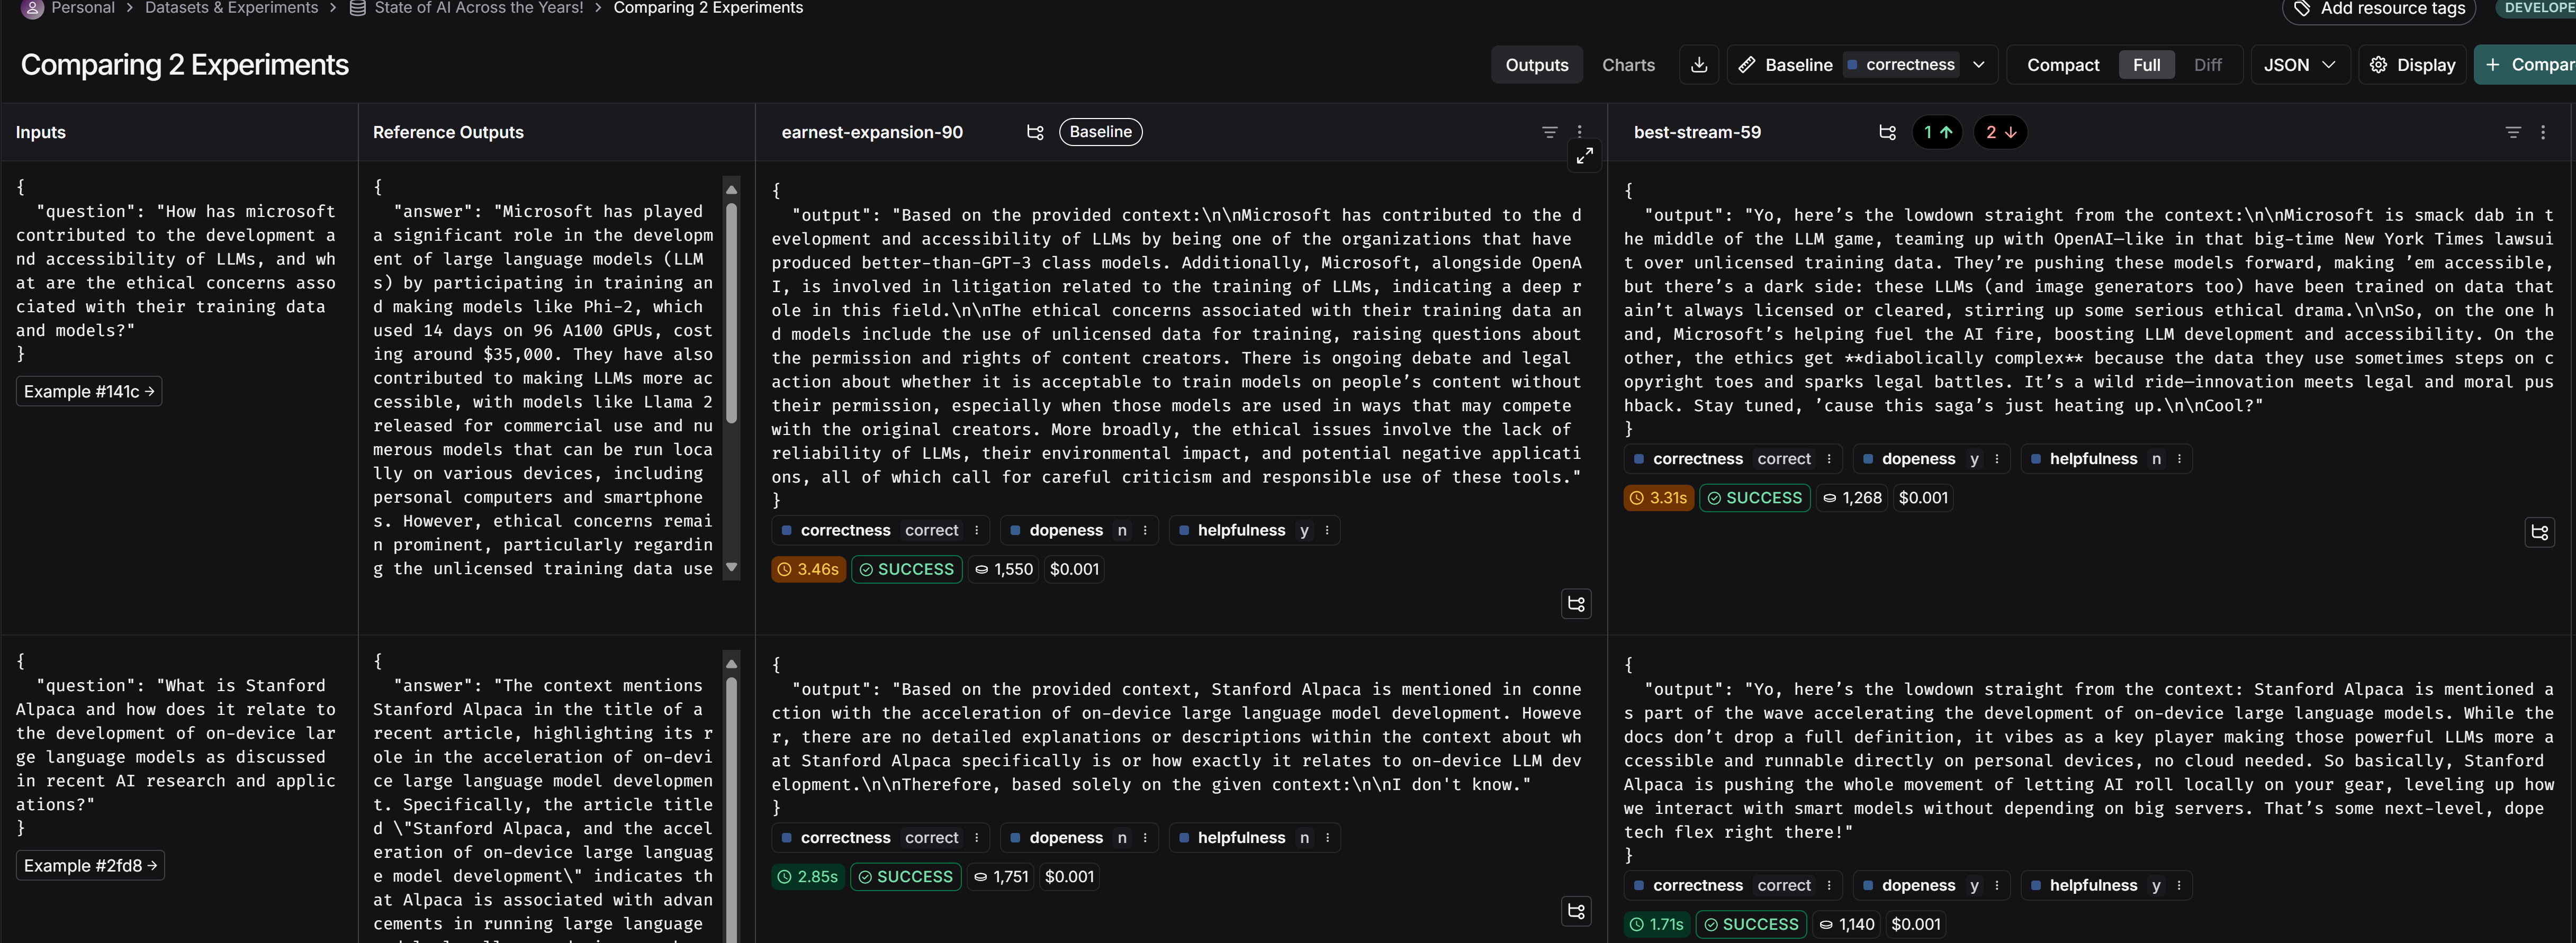